In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from libs.lib import *


d:\ads_test


In [2]:
exps_dir = "../../../exps/exp1"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/data"
os.makedirs(save_dir, exist_ok=True)


In [3]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ads1_prj_VGG16"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [4]:
# Dữ liệu
x_train = pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train = pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test = pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test = pd.read_excel(f'{save_dir}/y_test.xlsx')

In [5]:
from sklearn.metrics import f1_score
import tensorflow as tf
def f1_loss(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return 1 - f1

In [6]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [7]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [9]:
from keras import backend as K

def f1_score(y_true, y_pred):
    """
    F1 score metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [10]:
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
input_shape =(x_train.shape[1],1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.0001
kernel_size =3
filter_size=96


# Block 1
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv1')(x_input)
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

# Block 2
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

# Block 3
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv1')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv2')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

# Block 4
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

# Block 5
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block5_pool')(x)

# x = Flatten(name='flatten')(x)
# x = Dense(dense_units, activation='relu', name='fc1')(x)
# x = Dense(dense_units, activation='relu', name='fc2')(x)
# x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

x = GlobalAveragePooling1D()(x)
# x = GlobalMaxPooling1D()(x)
# x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification
x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

# Create model.
model = Model(x_input, x, name='vgg16')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',f1_score])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_accuracy',
    # min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.95,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)


In [11]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 34, 96)            384       
                                                                 
 block1_conv2 (Conv1D)       (None, 34, 96)            27744     
                                                                 
 block1_pool (MaxPooling1D)  (None, 17, 96)            0         
                                                                 
 block2_conv1 (Conv1D)       (None, 17, 192)           55488     
                                                                 
 block2_conv2 (Conv1D)       (None, 17, 192)           110784    
                                                                 
 block2_pool (MaxPooling1D)  (None, 8, 192)            0     

In [12]:
def show_pic(times):
    history=model.history.history
    fig,axes=plt.subplots(1,2, figsize=(15,8))
    axes[0].plot(pd.DataFrame(history['val_accuracy']))
    axes[0].set_title('Training Process')

    axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
    axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
    axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
    axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
    axes[1].set_title(f'Training Process in {times}')
    axes[1].legend()
    plt.show()


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.9347 - f1_score: 4.1511e-04INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.3s


146/146 [==============================] - 58s 383ms/step - loss: 0.2555 - accuracy: 0.9347 - f1_score: 4.1511e-04 - val_loss: 0.2461 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.2s


146/146 [==============================] - 62s 425ms/step - loss: 0.2311 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2390 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00
Epoch 3/10
146/146 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.2s


146/146 [==============================] - 56s 384ms/step - loss: 0.2201 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2270 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00
Epoch 4/10
146/146 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.3s


146/146 [==============================] - 55s 379ms/step - loss: 0.2124 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2163 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00
Epoch 5/10
146/146 [==============================] - 53s 365ms/step - loss: 0.2021 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2512 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00
Epoch 6/10
146/146 [==============================] - 53s 360ms/step - loss: 0.1990 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2179 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00
Epoch 7/10
146/146 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.3s


146/146 [==============================] - 56s 383ms/step - loss: 0.1923 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2091 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00
Epoch 8/10
146/146 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.4s


146/146 [==============================] - 53s 362ms/step - loss: 0.1938 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2032 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00
Epoch 9/10
146/146 [==============================] - 50s 344ms/step - loss: 0.1882 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2165 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00
Epoch 10/10
146/146 [==============================] - ETA: 0s - loss: 0.1861 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.3s


146/146 [==============================] - 55s 376ms/step - loss: 0.1861 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.1989 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00


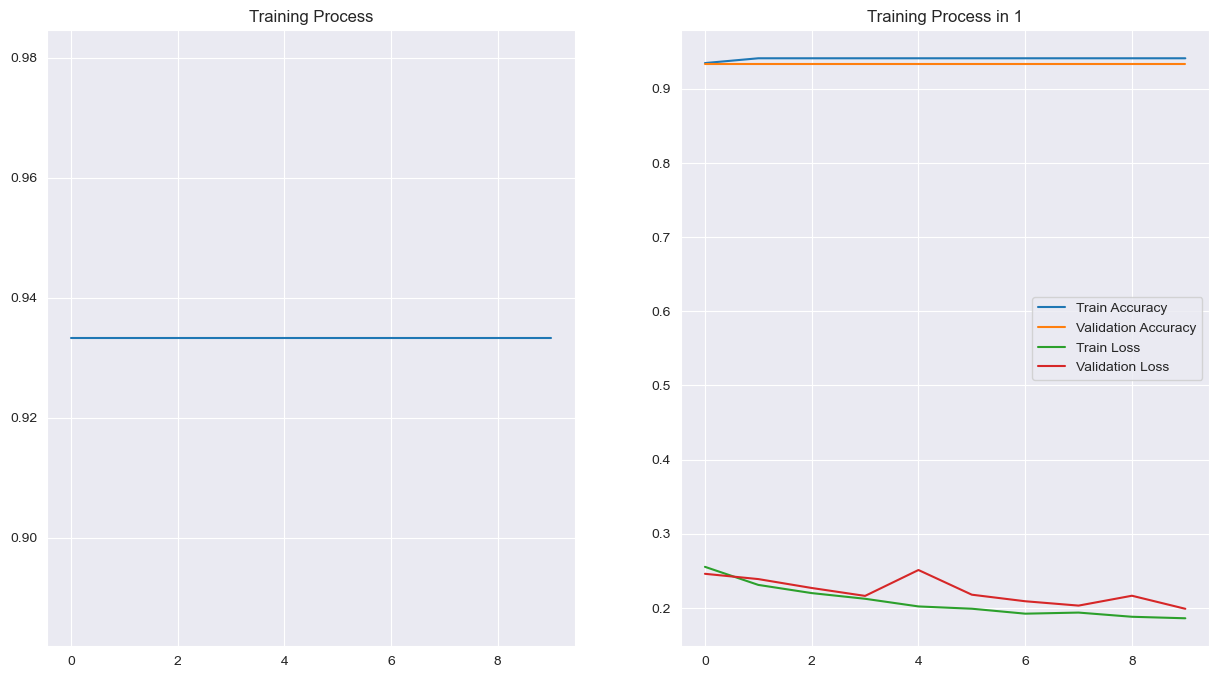

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.9398 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.4s


146/146 [==============================] - 66s 452ms/step - loss: 0.1889 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1733 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9398 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.3s


146/146 [==============================] - 64s 437ms/step - loss: 0.1879 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1696 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00
Epoch 3/10
146/146 [==============================] - 57s 387ms/step - loss: 0.1836 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1869 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00
Epoch 4/10
146/146 [==============================] - 53s 365ms/step - loss: 0.1833 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1826 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00
Epoch 5/10
146/146 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9398 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.3s


146/146 [==============================] - 57s 388ms/step - loss: 0.1801 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1678 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00
Epoch 6/10
146/146 [==============================] - 56s 384ms/step - loss: 0.1751 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1727 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00
Epoch 7/10
146/146 [==============================] - 54s 373ms/step - loss: 0.1736 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1754 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00
Epoch 8/10
146/146 [==============================] - 57s 392ms/step - loss: 0.1703 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1765 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00
Epoch 9/10
146/146 [==============================] - 62s 422ms/step - loss: 0.1663 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1786 - val_accuracy: 0.9448 - val_f1_score: 0.1194
Epoch 10/10
146/146 [===================

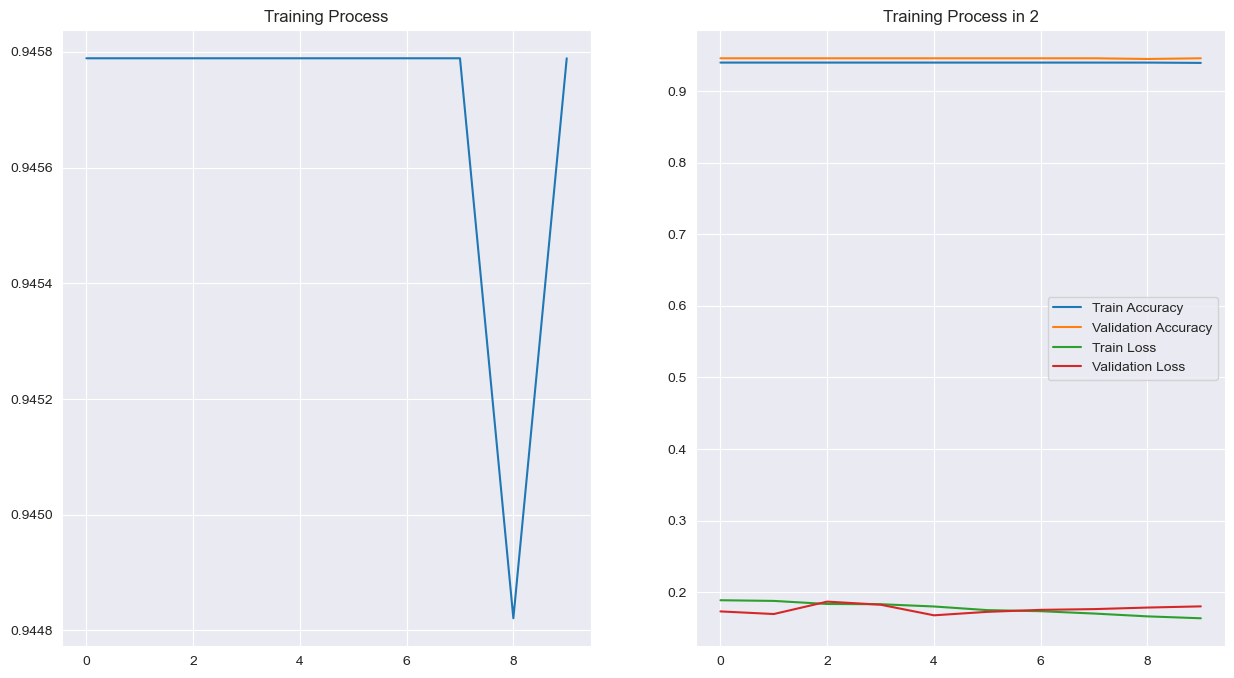

Epoch 1/10
146/146 [==============================] - 57s 391ms/step - loss: 0.1634 - accuracy: 0.9412 - f1_score: 0.0516 - val_loss: 0.1701 - val_accuracy: 0.9419 - val_f1_score: 0.1147
Epoch 2/10
146/146 [==============================] - 55s 376ms/step - loss: 0.1554 - accuracy: 0.9405 - f1_score: 0.1113 - val_loss: 0.1769 - val_accuracy: 0.9380 - val_f1_score: 0.0000e+00
Epoch 3/10
146/146 [==============================] - 51s 350ms/step - loss: 0.1460 - accuracy: 0.9440 - f1_score: 0.1961 - val_loss: 0.1842 - val_accuracy: 0.9429 - val_f1_score: 0.2736
Epoch 4/10
146/146 [==============================] - 54s 370ms/step - loss: 0.1460 - accuracy: 0.9447 - f1_score: 0.2997 - val_loss: 0.1968 - val_accuracy: 0.9409 - val_f1_score: 0.1648
Epoch 5/10
146/146 [==============================] - 53s 362ms/step - loss: 0.1398 - accuracy: 0.9475 - f1_score: 0.3250 - val_loss: 0.1994 - val_accuracy: 0.9390 - val_f1_score: 0.0482
Epoch 6/10
146/146 [==============================] - 53s 364

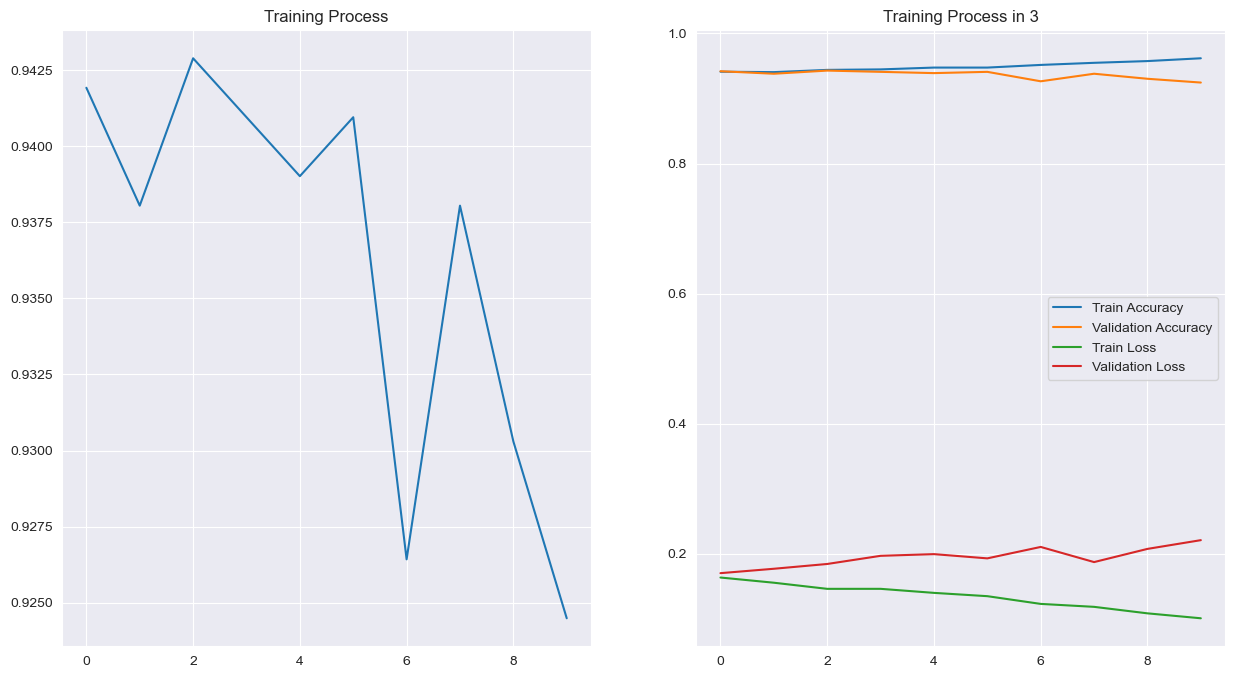

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9609 - f1_score: 0.5729INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.3s


146/146 [==============================] - 58s 397ms/step - loss: 0.1078 - accuracy: 0.9609 - f1_score: 0.5729 - val_loss: 0.0842 - val_accuracy: 0.9710 - val_f1_score: 0.5467
Epoch 2/10
146/146 [==============================] - 50s 343ms/step - loss: 0.0912 - accuracy: 0.9658 - f1_score: 0.6031 - val_loss: 0.1133 - val_accuracy: 0.9603 - val_f1_score: 0.3955
Epoch 3/10
146/146 [==============================] - 53s 361ms/step - loss: 0.0843 - accuracy: 0.9687 - f1_score: 0.6569 - val_loss: 0.0967 - val_accuracy: 0.9603 - val_f1_score: 0.4971
Epoch 4/10
146/146 [==============================] - 58s 400ms/step - loss: 0.0778 - accuracy: 0.9705 - f1_score: 0.6650 - val_loss: 0.0891 - val_accuracy: 0.9681 - val_f1_score: 0.5623
Epoch 5/10
146/146 [==============================] - 60s 413ms/step - loss: 0.0727 - accuracy: 0.9731 - f1_score: 0.6940 - val_loss: 0.1287 - val_accuracy: 0.9545 - val_f1_score: 0.4896
Epoch 6/10
146/146 [==============================] - 58s 395ms/step - loss:

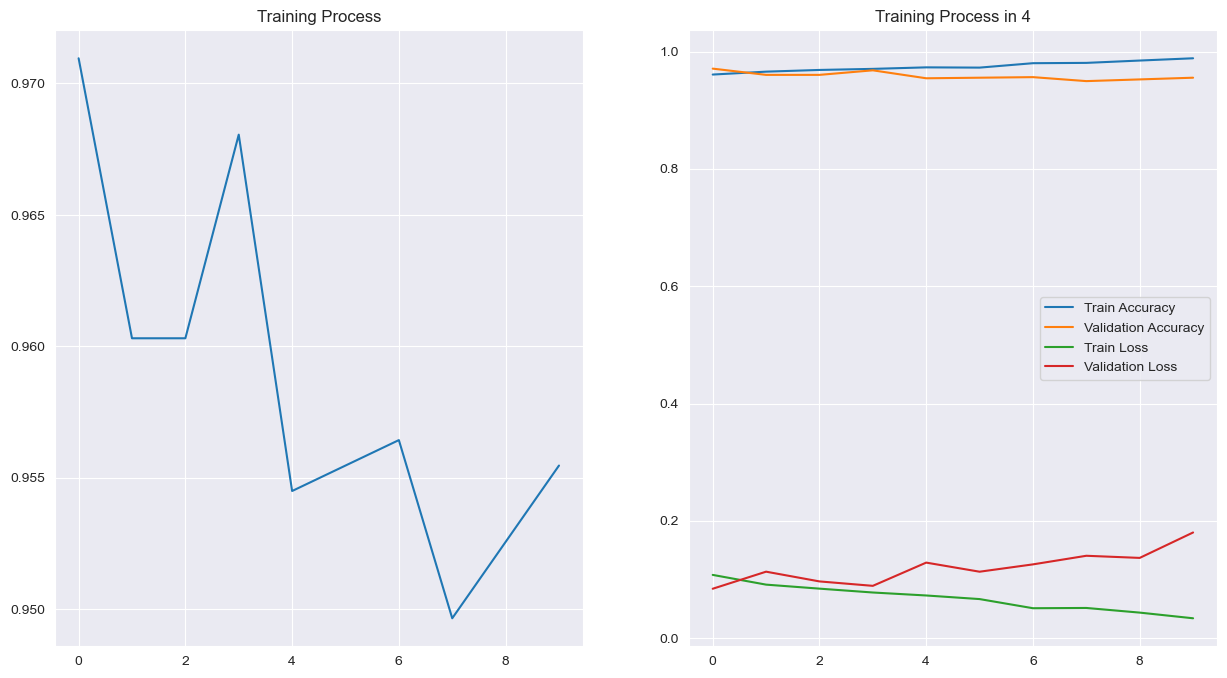

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9847 - f1_score: 0.8347INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.4s


146/146 [==============================] - 55s 377ms/step - loss: 0.0430 - accuracy: 0.9847 - f1_score: 0.8347 - val_loss: 0.0297 - val_accuracy: 0.9884 - val_f1_score: 0.7394
Epoch 2/10
146/146 [==============================] - 53s 362ms/step - loss: 0.0365 - accuracy: 0.9867 - f1_score: 0.8417 - val_loss: 0.0403 - val_accuracy: 0.9855 - val_f1_score: 0.7579
Epoch 3/10
146/146 [==============================] - 54s 371ms/step - loss: 0.0284 - accuracy: 0.9898 - f1_score: 0.8851 - val_loss: 0.0687 - val_accuracy: 0.9729 - val_f1_score: 0.5997
Epoch 4/10
146/146 [==============================] - 52s 355ms/step - loss: 0.0368 - accuracy: 0.9851 - f1_score: 0.8092 - val_loss: 0.0367 - val_accuracy: 0.9864 - val_f1_score: 0.7516
Epoch 5/10
146/146 [==============================] - 57s 390ms/step - loss: 0.0265 - accuracy: 0.9902 - f1_score: 0.8819 - val_loss: 0.0551 - val_accuracy: 0.9797 - val_f1_score: 0.6591
Epoch 6/10
146/146 [==============================] - 62s 426ms/step - loss:

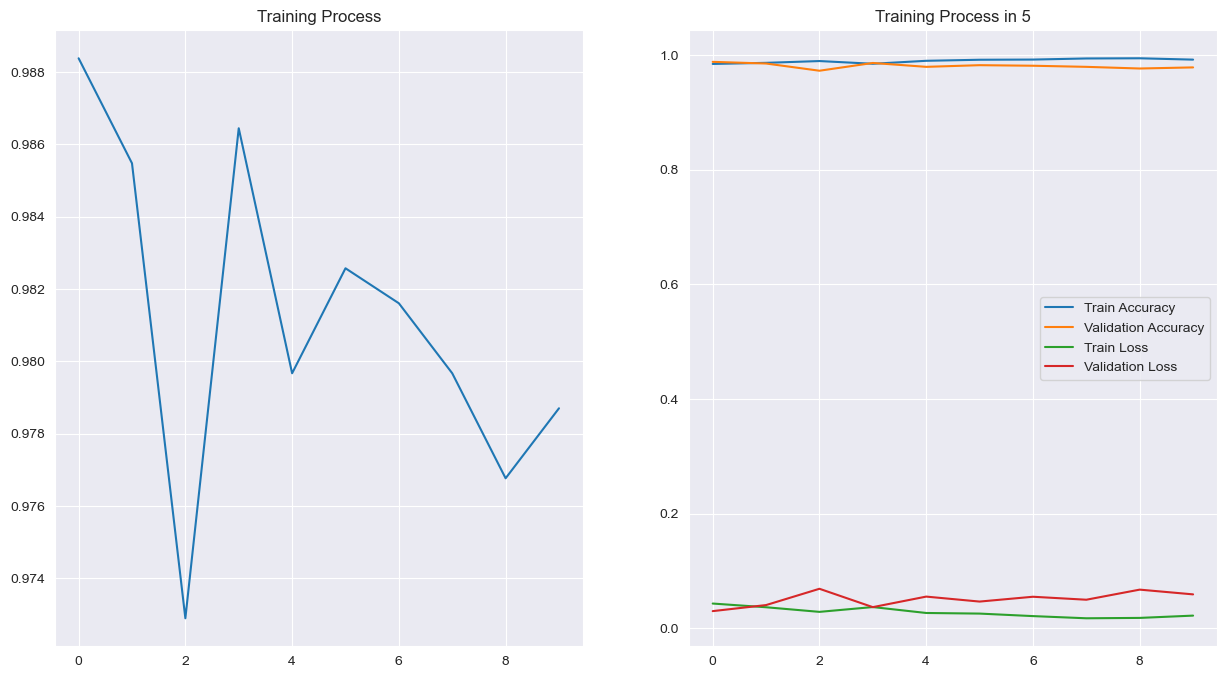

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9920 - f1_score: 0.8964INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.4s


146/146 [==============================] - 56s 380ms/step - loss: 0.0207 - accuracy: 0.9920 - f1_score: 0.8964 - val_loss: 0.0089 - val_accuracy: 0.9971 - val_f1_score: 0.9085
Epoch 2/10
146/146 [==============================] - 52s 354ms/step - loss: 0.0151 - accuracy: 0.9944 - f1_score: 0.9106 - val_loss: 0.0173 - val_accuracy: 0.9942 - val_f1_score: 0.9040
Epoch 3/10
146/146 [==============================] - 51s 347ms/step - loss: 0.0170 - accuracy: 0.9939 - f1_score: 0.8922 - val_loss: 0.0161 - val_accuracy: 0.9952 - val_f1_score: 0.9007
Epoch 4/10
146/146 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9941 - f1_score: 0.8862INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.4s


146/146 [==============================] - 54s 373ms/step - loss: 0.0198 - accuracy: 0.9941 - f1_score: 0.8862 - val_loss: 0.0059 - val_accuracy: 0.9990 - val_f1_score: 0.9346
Epoch 5/10
146/146 [==============================] - 50s 340ms/step - loss: 0.0160 - accuracy: 0.9940 - f1_score: 0.9323 - val_loss: 0.0151 - val_accuracy: 0.9942 - val_f1_score: 0.8947
Epoch 6/10
146/146 [==============================] - 54s 372ms/step - loss: 0.0142 - accuracy: 0.9942 - f1_score: 0.9041 - val_loss: 0.0319 - val_accuracy: 0.9894 - val_f1_score: 0.8072
Epoch 7/10
146/146 [==============================] - 54s 373ms/step - loss: 0.0121 - accuracy: 0.9961 - f1_score: 0.9263 - val_loss: 0.0375 - val_accuracy: 0.9874 - val_f1_score: 0.8212
Epoch 8/10
146/146 [==============================] - 53s 361ms/step - loss: 0.0075 - accuracy: 0.9976 - f1_score: 0.9368 - val_loss: 0.0229 - val_accuracy: 0.9923 - val_f1_score: 0.8747
Epoch 9/10
146/146 [==============================] - 55s 375ms/step - loss:

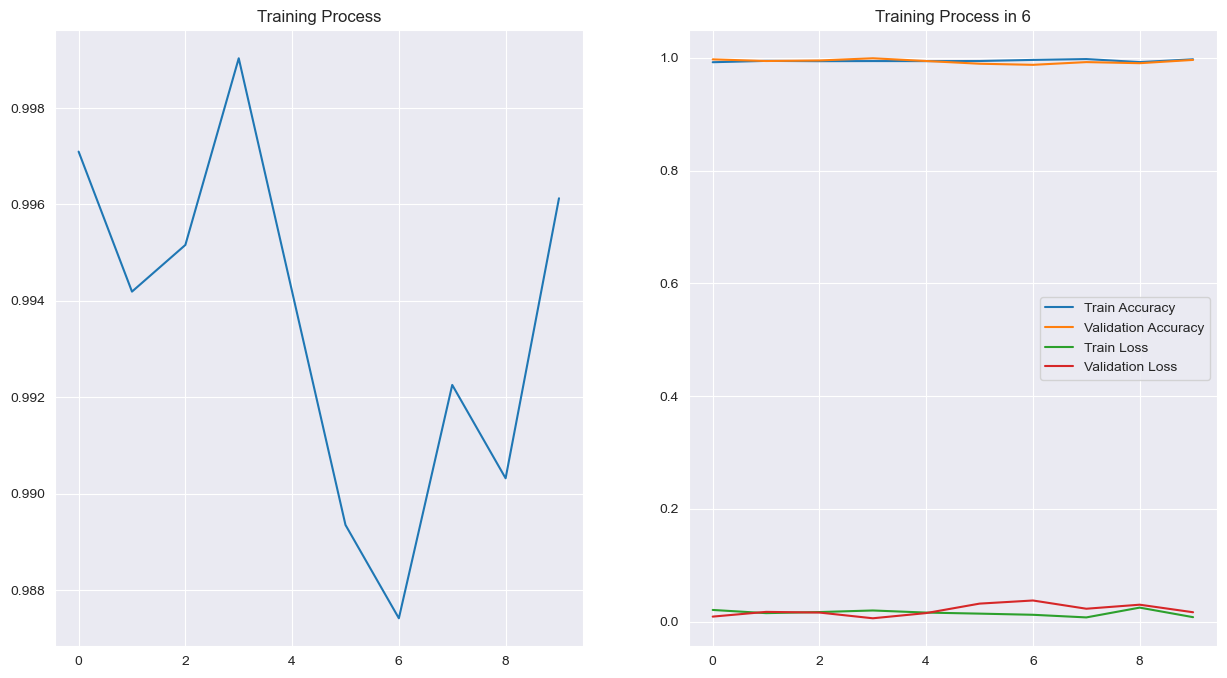

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9946 - f1_score: 0.9373INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.3s


146/146 [==============================] - 59s 403ms/step - loss: 0.0159 - accuracy: 0.9946 - f1_score: 0.9373 - val_loss: 0.0042 - val_accuracy: 0.9990 - val_f1_score: 0.9373
Epoch 2/10
146/146 [==============================] - 54s 372ms/step - loss: 0.0168 - accuracy: 0.9931 - f1_score: 0.9254 - val_loss: 0.0124 - val_accuracy: 0.9942 - val_f1_score: 0.9055
Epoch 3/10
146/146 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9969 - f1_score: 0.9413INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_183650-mptp4b3m\files\model-best)... Done. 0.3s


146/146 [==============================] - 57s 390ms/step - loss: 0.0099 - accuracy: 0.9969 - f1_score: 0.9413 - val_loss: 0.0035 - val_accuracy: 0.9990 - val_f1_score: 0.9358
Epoch 4/10
146/146 [==============================] - 59s 404ms/step - loss: 0.0150 - accuracy: 0.9949 - f1_score: 0.9160 - val_loss: 0.0207 - val_accuracy: 0.9923 - val_f1_score: 0.8428
Epoch 5/10
146/146 [==============================] - 60s 411ms/step - loss: 0.0112 - accuracy: 0.9965 - f1_score: 0.9356 - val_loss: 0.0142 - val_accuracy: 0.9952 - val_f1_score: 0.9149
Epoch 6/10
146/146 [==============================] - 53s 361ms/step - loss: 0.0103 - accuracy: 0.9967 - f1_score: 0.9514 - val_loss: 0.0382 - val_accuracy: 0.9884 - val_f1_score: 0.8176
Epoch 7/10
146/146 [==============================] - 53s 362ms/step - loss: 0.0100 - accuracy: 0.9968 - f1_score: 0.9407 - val_loss: 0.0368 - val_accuracy: 0.9864 - val_f1_score: 0.8308
Epoch 8/10
146/146 [==============================] - 53s 365ms/step - loss:

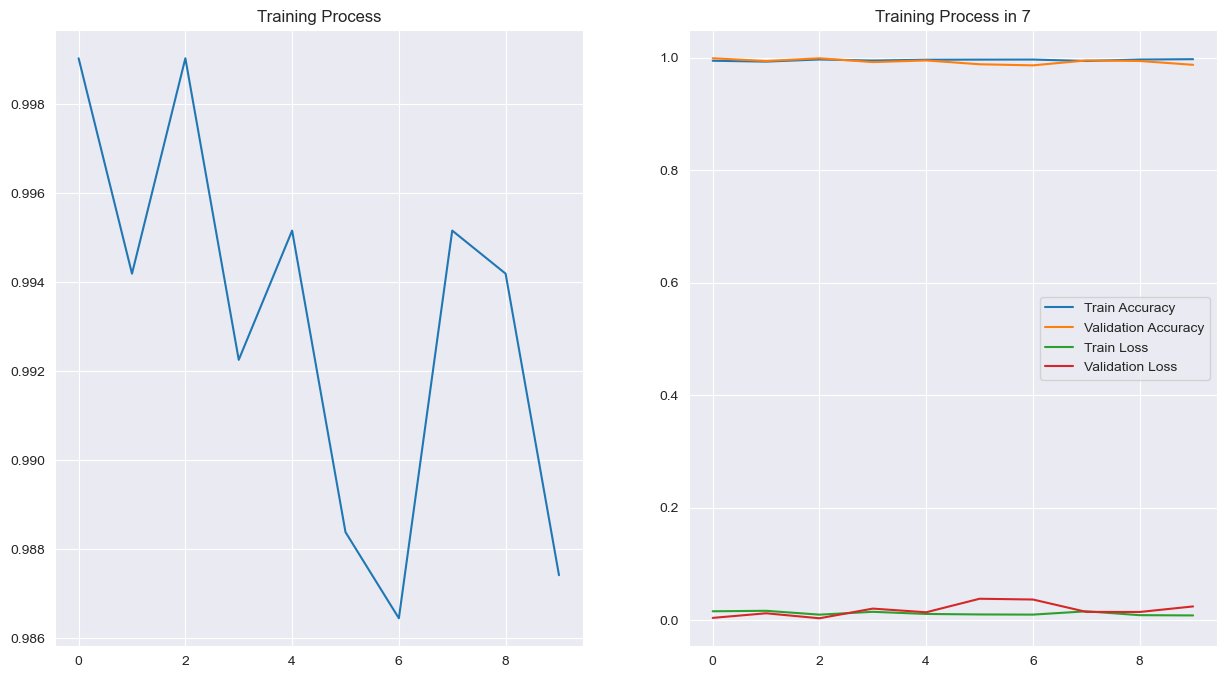

Epoch 1/10
146/146 [==============================] - 58s 398ms/step - loss: 0.0099 - accuracy: 0.9975 - f1_score: 0.9393 - val_loss: 0.0089 - val_accuracy: 0.9971 - val_f1_score: 0.9239
Epoch 2/10
146/146 [==============================] - 58s 396ms/step - loss: 0.0124 - accuracy: 0.9954 - f1_score: 0.9351 - val_loss: 0.0279 - val_accuracy: 0.9884 - val_f1_score: 0.7870
Epoch 3/10
146/146 [==============================] - 57s 391ms/step - loss: 0.0105 - accuracy: 0.9962 - f1_score: 0.9412 - val_loss: 0.0149 - val_accuracy: 0.9952 - val_f1_score: 0.9041
Epoch 4/10
146/146 [==============================] - 52s 355ms/step - loss: 0.0142 - accuracy: 0.9951 - f1_score: 0.9242 - val_loss: 0.0163 - val_accuracy: 0.9971 - val_f1_score: 0.8674
Epoch 5/10
146/146 [==============================] - 51s 350ms/step - loss: 0.0109 - accuracy: 0.9961 - f1_score: 0.9423 - val_loss: 0.0106 - val_accuracy: 0.9952 - val_f1_score: 0.8993
Epoch 6/10
146/146 [==============================] - 54s 369ms/s

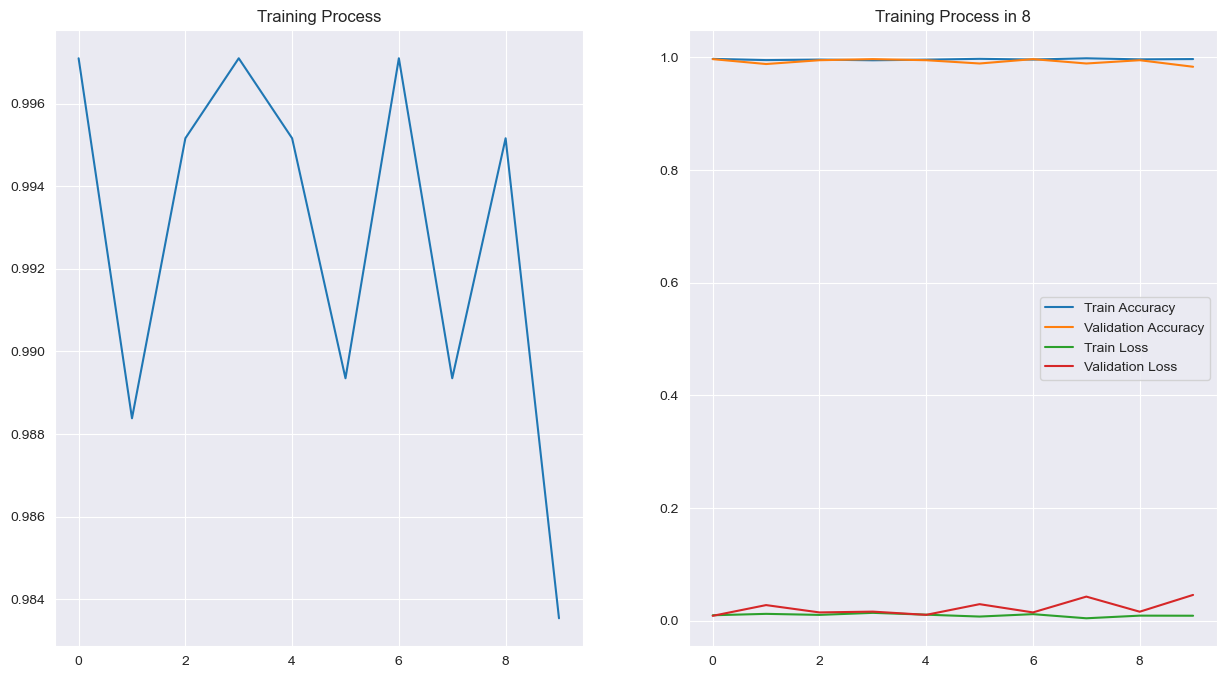

Epoch 1/10
146/146 [==============================] - 53s 366ms/step - loss: 0.0168 - accuracy: 0.9944 - f1_score: 0.9399 - val_loss: 0.0090 - val_accuracy: 0.9971 - val_f1_score: 0.9832
Epoch 2/10
146/146 [==============================] - 58s 398ms/step - loss: 0.0072 - accuracy: 0.9978 - f1_score: 0.9598 - val_loss: 0.0055 - val_accuracy: 0.9981 - val_f1_score: 0.9829
Epoch 3/10
146/146 [==============================] - 53s 366ms/step - loss: 0.0110 - accuracy: 0.9961 - f1_score: 0.9286 - val_loss: 0.0174 - val_accuracy: 0.9942 - val_f1_score: 0.9027
Epoch 4/10
146/146 [==============================] - 54s 373ms/step - loss: 0.0069 - accuracy: 0.9984 - f1_score: 0.9633 - val_loss: 0.0054 - val_accuracy: 0.9981 - val_f1_score: 0.9765
Epoch 5/10
146/146 [==============================] - 55s 375ms/step - loss: 0.0084 - accuracy: 0.9977 - f1_score: 0.9599 - val_loss: 0.0375 - val_accuracy: 0.9884 - val_f1_score: 0.8449
Epoch 6/10
146/146 [==============================] - 55s 374ms/s

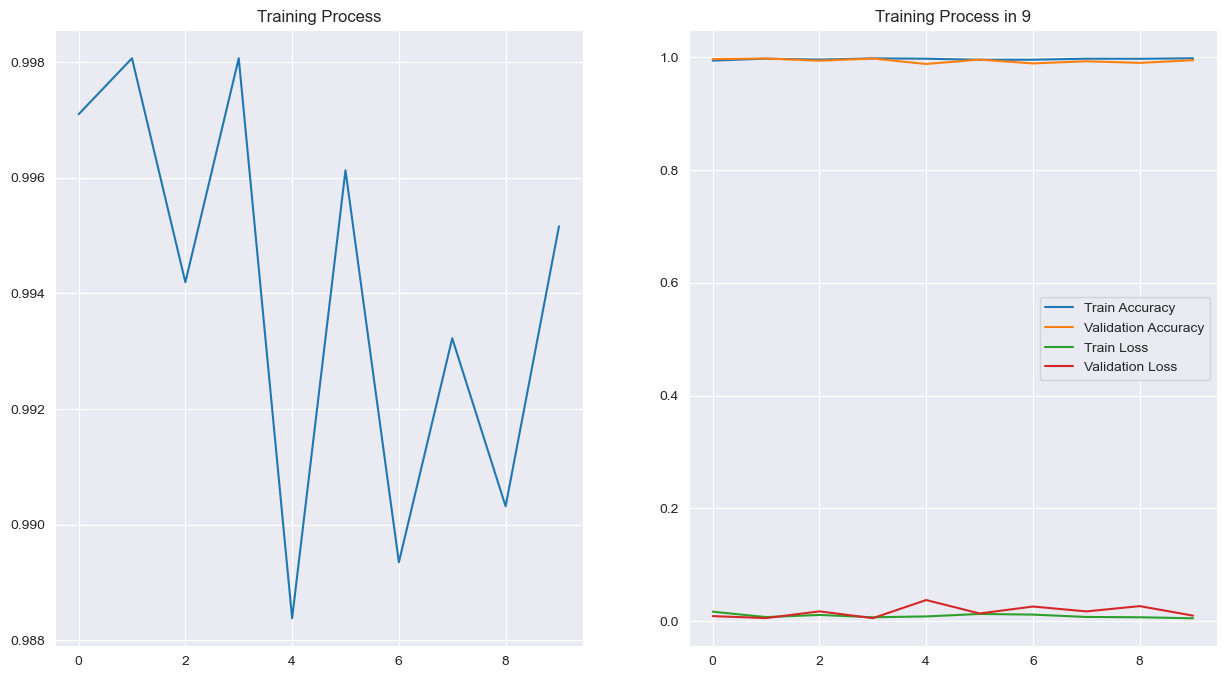

Epoch 1/10
146/146 [==============================] - 53s 365ms/step - loss: 0.0154 - accuracy: 0.9944 - f1_score: 0.9076 - val_loss: 0.0162 - val_accuracy: 0.9971 - val_f1_score: 0.9190
Epoch 2/10
146/146 [==============================] - 54s 369ms/step - loss: 0.0090 - accuracy: 0.9976 - f1_score: 0.9582 - val_loss: 0.0082 - val_accuracy: 0.9981 - val_f1_score: 0.9307
Epoch 3/10
146/146 [==============================] - 54s 367ms/step - loss: 0.0021 - accuracy: 0.9992 - f1_score: 0.9637 - val_loss: 0.0256 - val_accuracy: 0.9952 - val_f1_score: 0.9117
Epoch 4/10
146/146 [==============================] - 52s 359ms/step - loss: 0.0080 - accuracy: 0.9974 - f1_score: 0.9520 - val_loss: 0.0055 - val_accuracy: 0.9981 - val_f1_score: 0.9229
Epoch 5/10
146/146 [==============================] - 57s 391ms/step - loss: 0.0057 - accuracy: 0.9984 - f1_score: 0.9572 - val_loss: 0.0431 - val_accuracy: 0.9952 - val_f1_score: 0.8988
Epoch 6/10
146/146 [==============================] - 59s 407ms/s

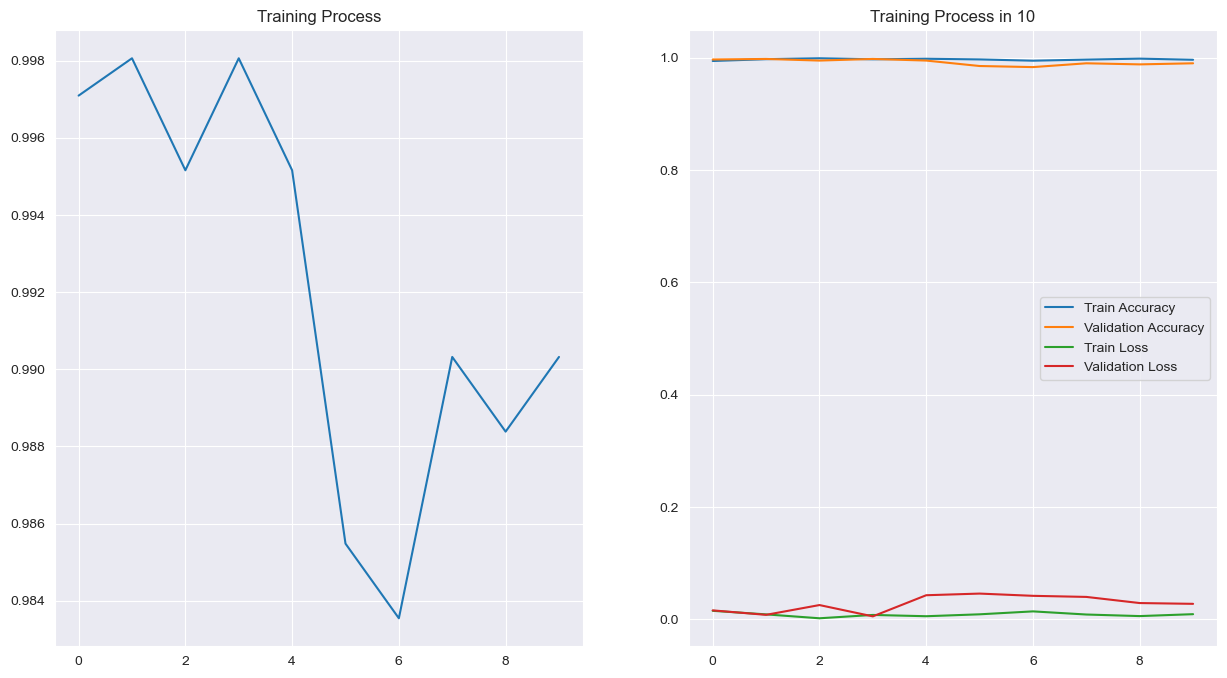

In [13]:
# Số lượng folds
n_splits = 10

# KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)


times=0

# Tạo và đào tạo mô hình với K-Fold
# Tạo và đào tạo mô hình với K-Fold
for train_index, val_index in kf.split(x_train):
    times+=1
    X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    # Chuyển đổi tf.Tensor thành mảng NumPy nếu cần thiết
    X_train_fold = X_train_fold.numpy() if isinstance(X_train_fold, tf.Tensor) else X_train_fold
    y_train_fold = y_train_fold.numpy() if isinstance(y_train_fold, tf.Tensor) else y_train_fold
    X_val_fold = X_val_fold.numpy() if isinstance(X_val_fold, tf.Tensor) else X_val_fold
    y_val_fold = y_val_fold.numpy() if isinstance(y_val_fold, tf.Tensor) else y_val_fold
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=64, validation_data=(X_val_fold, y_val_fold),callbacks=[wandb.keras.WandbCallback()])
    show_pic(times)


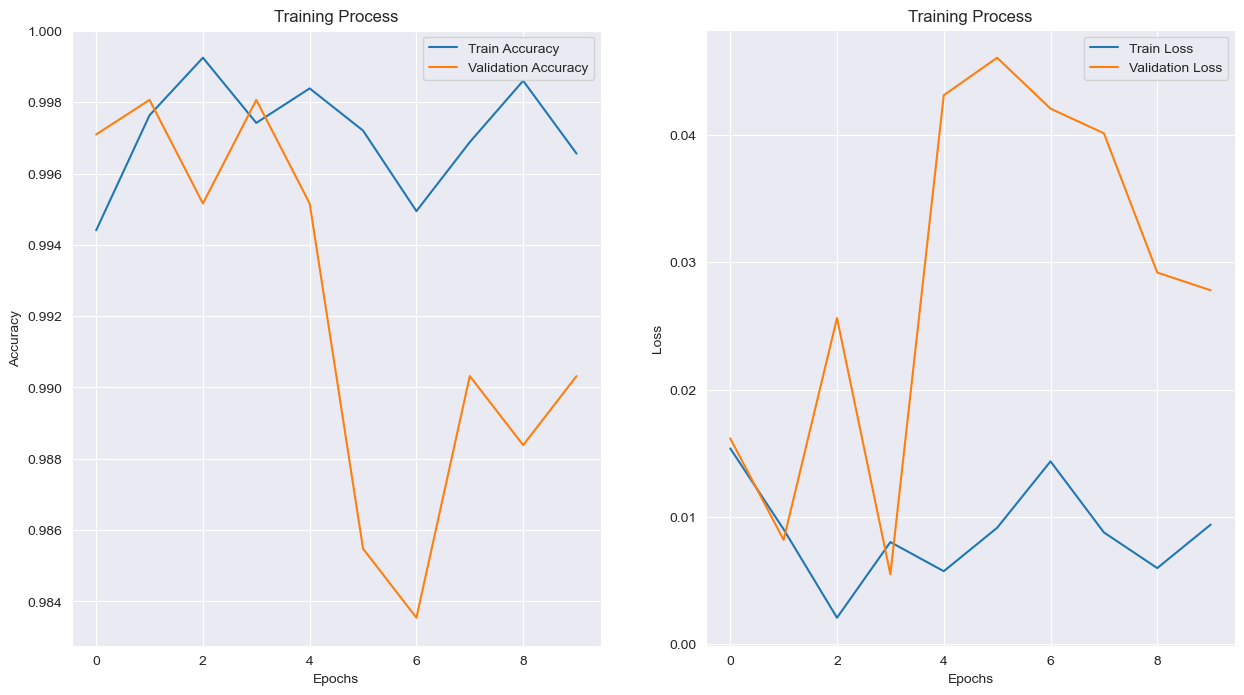

<Figure size 640x480 with 0 Axes>

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history = model.history.history

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')


In [15]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test, predictions)
accuracy

160/160 [==============================] - 2s 13ms/step


0.9396738062487718

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.9396738062487718
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       307
           0       0.94      1.00      0.97      4782

    accuracy                           0.94      5089
   macro avg       0.47      0.50      0.48      5089
weighted avg       0.88      0.94      0.91      5089



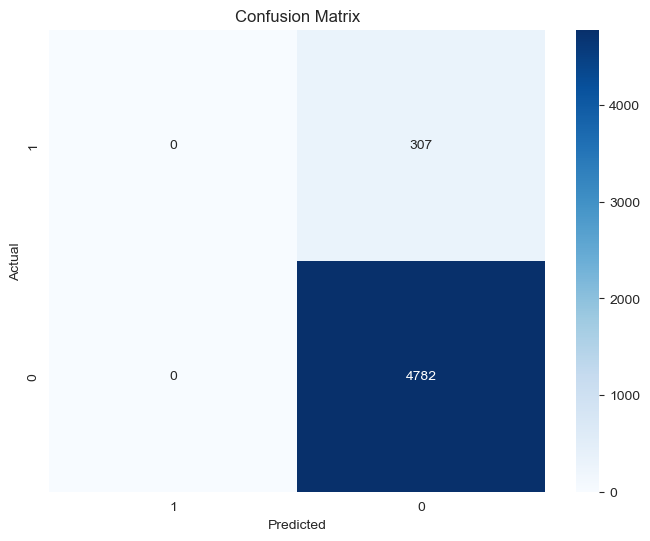

In [17]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

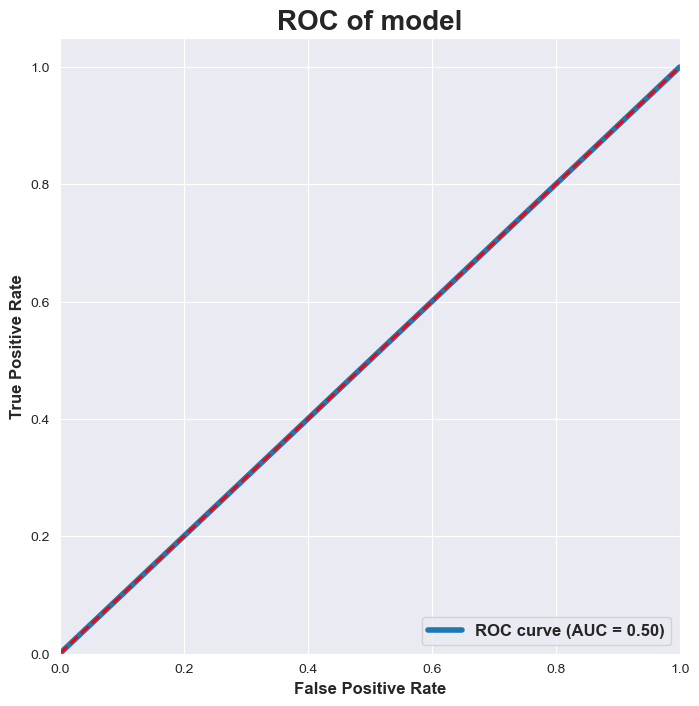

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [19]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [20]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------


In [22]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['FraudFound_P']==1]))*100}% so với thực tế")

Số lần dự đoán đúng: 4782 chiếm khoảng 93.96738062487718% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 0 chiếm khoảng 0.0% so với thực tế
